# Naive bayes classifier: Google Play Store reviews

## 1. Data Loading

In [42]:
# Handle import up-front
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV

from utils import cross_val

### 1.1. Load the data

In [2]:
# Load the data from the URL provided in the project tutorial
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv')

### 1.2. Inspect the data

In [3]:
data_df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   package_name  891 non-null    object
 1   review        891 non-null    object
 2   polarity      891 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.0+ KB


### 1.3. Train-test split

In [5]:
# Separate features from labels
labels=data_df['polarity']
features=data_df.drop('polarity', axis=1)

# Split the data into training and testing features and labels
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    test_size=0.25,
    random_state=315
)

### 1.4. Data encoding

In [25]:
# Get just the reviews from the testing data
testing_reviews=testing_features['review']

# Fit the vectorizer and transform the training reviews into word counts
vec_model=CountVectorizer(stop_words="english")
testing_word_counts=vec_model.fit_transform(testing_reviews).toarray()

print(f'Testing word count matrix has {testing_word_counts.shape[0]} rows and {testing_word_counts.shape[1]} columns')

Testing word count matrix has 223 rows and 1686 columns


In [10]:
# Get just the reviews from the training data
training_reviews=training_features['review']

# Fit the vectorizer and transform the test reviews into word counts
vec_model=CountVectorizer(stop_words="english")
training_word_counts=vec_model.fit_transform(training_reviews).toarray()

print(f'Training word count matrix has {training_word_counts.shape[0]} rows and {training_word_counts.shape[1]} columns')

Training word count matrix has 668 rows and 3151 columns


## 2. EDA

### 2.1. Baseline model performance

In [13]:
# Define the model
model=MultinomialNB()

# Cross-validate the model
scores=cross_val(model, training_word_counts, training_labels)

Cross-validation accuracy: 80.99 +/- 4.17%


### 2.2. Missing, and/or extreme values

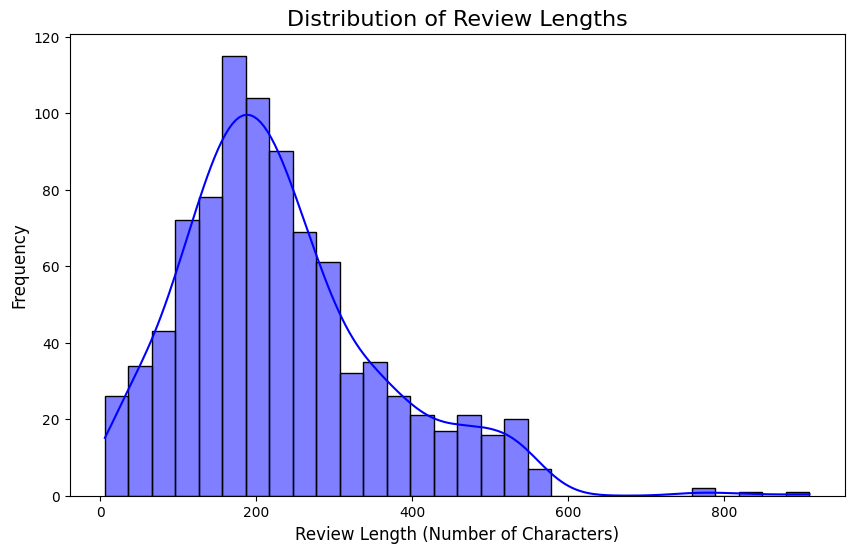

In [14]:
# Try plotting the distribution of review lengths!

data_df['review_length'] = data_df['review'].apply(len) 

plt.figure(figsize=(10, 6)) 
sns.histplot(data_df['review_length'], bins=30, kde=True, color='blue')

plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length (Number of Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

### 2.3. Feature selection

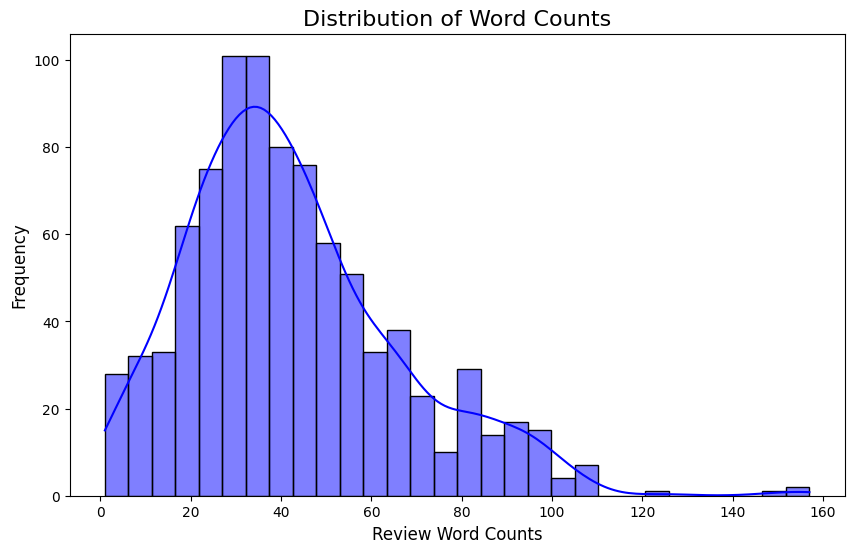

In [15]:
# After encoding we have over three thousand features - do we need all of them? Try plotting the distribution of word counts!
word_counts = training_word_counts.sum().tolist()

data_df['word_counts'] = data_df['review'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6)) 
sns.histplot(data_df['word_counts'], bins=30, kde=True, color='blue')

plt.title('Distribution of Word Counts', fontsize=16)
plt.xlabel('Review Word Counts', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

## 3. Model training

In [21]:
# Remove package_name (not needed)
data_df = data_df.drop(columns=['package_name'])

# Strip whitespace and transform to lowercase
data_df["review"] = data_df["review"].str.strip().str.lower()

In [ ]:
# Define the models
models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'BernoulliNB': BernoulliNB()
}

# Train the models
for name, model in models.items():
    model.fit(training_word_counts, training_labels)

In [39]:
for name, model in models.items():
    # Cross-validation
    cv_scores = cross_val_score(model, training_word_counts, training_labels, cv=5)
    print(f'{name} Cross-Validation Accuracy: {cv_scores.mean():.4f}')
    
    # Predictions on testing data
    predictions = model.predict(testing_word_counts)
    
    # Evaluation metrics
    accuracy = accuracy_score(testing_labels, predictions)
    precision = precision_score(testing_labels, predictions, average='weighted')
    recall = recall_score(testing_labels, predictions, average='weighted')
    f1 = f1_score(testing_labels, predictions, average='weighted')
    
    # Print the evaluation metrics
    print(f'{name} Test accuracy: {accuracy:.4f}')
    print(f'{name} Test precision: {precision:.4f}')

    print('~~~')

GaussianNB Cross-Validation Accuracy: 0.7500
GaussianNB Test accuracy: 0.7534
GaussianNB Test precision: 0.7480
~~~
MultinomialNB Cross-Validation Accuracy: 0.8054
MultinomialNB Test accuracy: 0.7713
MultinomialNB Test precision: 0.7671
~~~
BernoulliNB Cross-Validation Accuracy: 0.7470
BernoulliNB Test accuracy: 0.7265
BernoulliNB Test precision: 0.7317
~~~


## 4. Model optimization

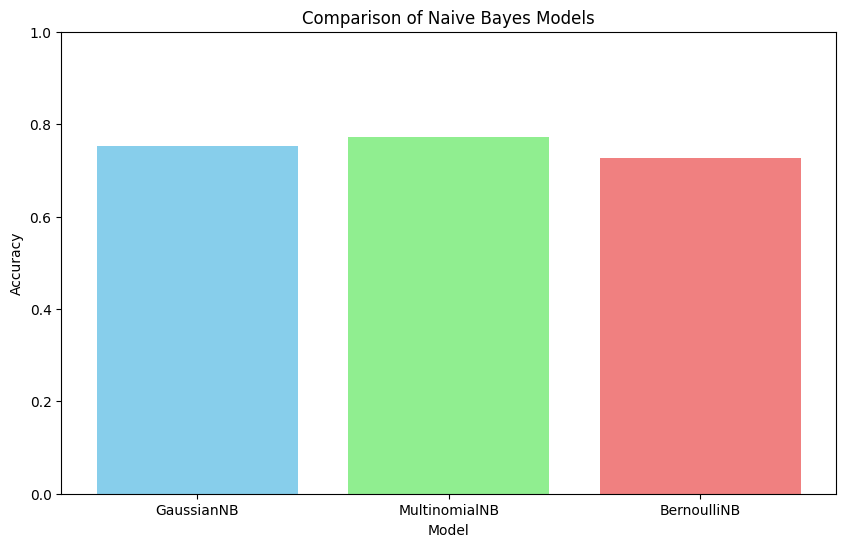

In [43]:
# For this project we will compare the three types of naive bayes models avalible in Scikit-learn: GaussianNB, MultinomialNB or BernoulliNB, rather than running hyperparameter optimization. Also, feel free to experiment and try any other tricks or methods you can find via research or come up with yourself to improve model performance!

# Visualization of results
import matplotlib.pyplot as plt

model_names = list(models.keys())
accuracies = [accuracy_score(testing_labels, models[name].predict(testing_word_counts)) for name in model_names]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Comparison of Naive Bayes Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

## 5. Final model evaluation

Multinomial has a slight edge over Gaussian or Bernoulli.